# 0.0. IMPORTS

In [96]:
import math
import numpy  as np
import pandas as pd
import inflection
import datetime

import seaborn as sns

from scipy                 import stats
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## 0.1. Helper functions

In [2]:
def cramer_v(x, y):
    
    cm = pd.crosstab( x, y ).values    
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n - 1) )
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt( (chi2corr / n) / min( kcorr - 1, rcorr - 1 ) )  


    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
128671,447,2,2015-04-07,6274,738,1,0,0,1,a,c,1510.0,9.0,2013.0,0,NaN,NaN,NaN


# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename columns

df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)
                                                                                                            
# promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
              5: 'May', 6: 'Jun',  7: 'Jul', 8: 'Aug',
              9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }  

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)  
                                     
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )                                     
                                     

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attrs = df1.select_dtypes( include=['int64', 'float64'] )
cat_attrs = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attrs.apply( np.mean )).T
ct2 = pd.DataFrame(num_attrs.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attrs.apply( np.std )).T
d2 = pd.DataFrame(num_attrs.apply( min )).T
d3 = pd.DataFrame(num_attrs.apply( max )).T
d4 = pd.DataFrame(num_attrs.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attrs.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attrs.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

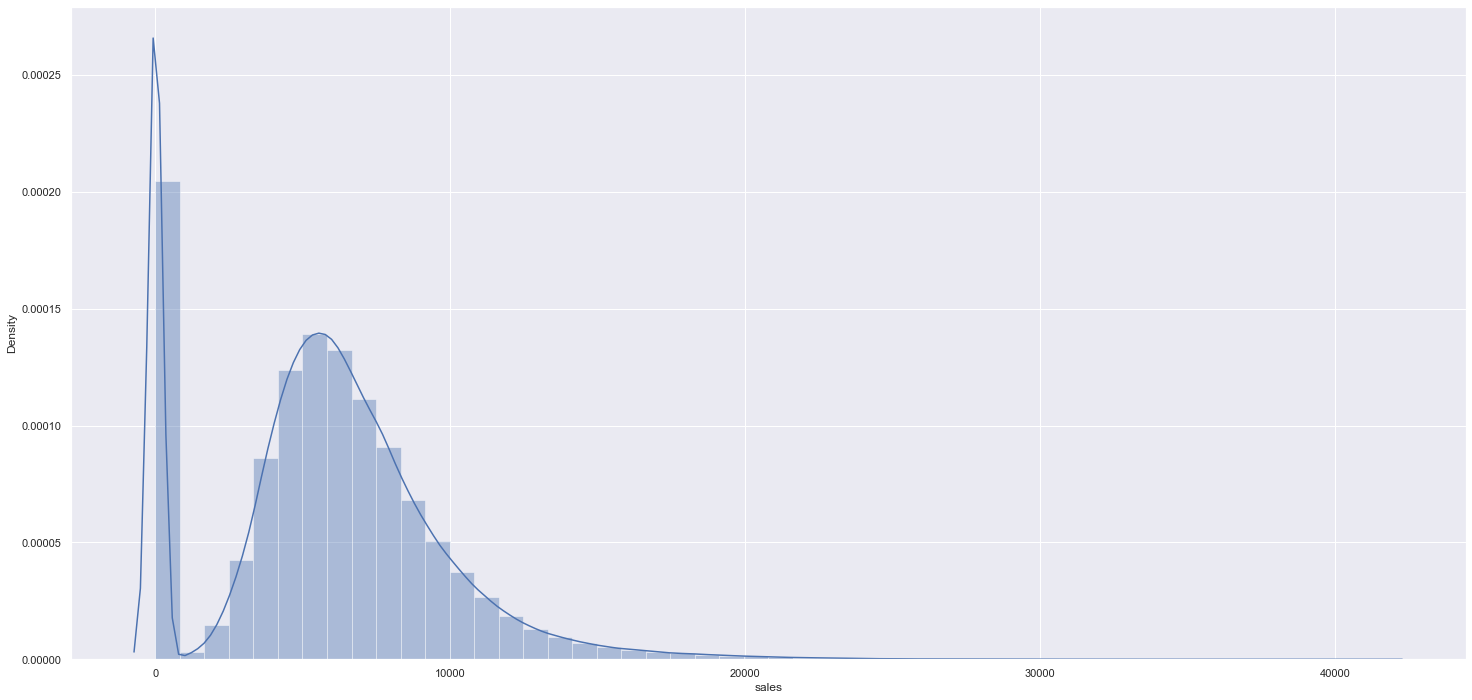

In [18]:
sns.distplot( df1['sales'] )

## 1.7.2 Categorical Attributes

In [19]:
cat_attrs.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

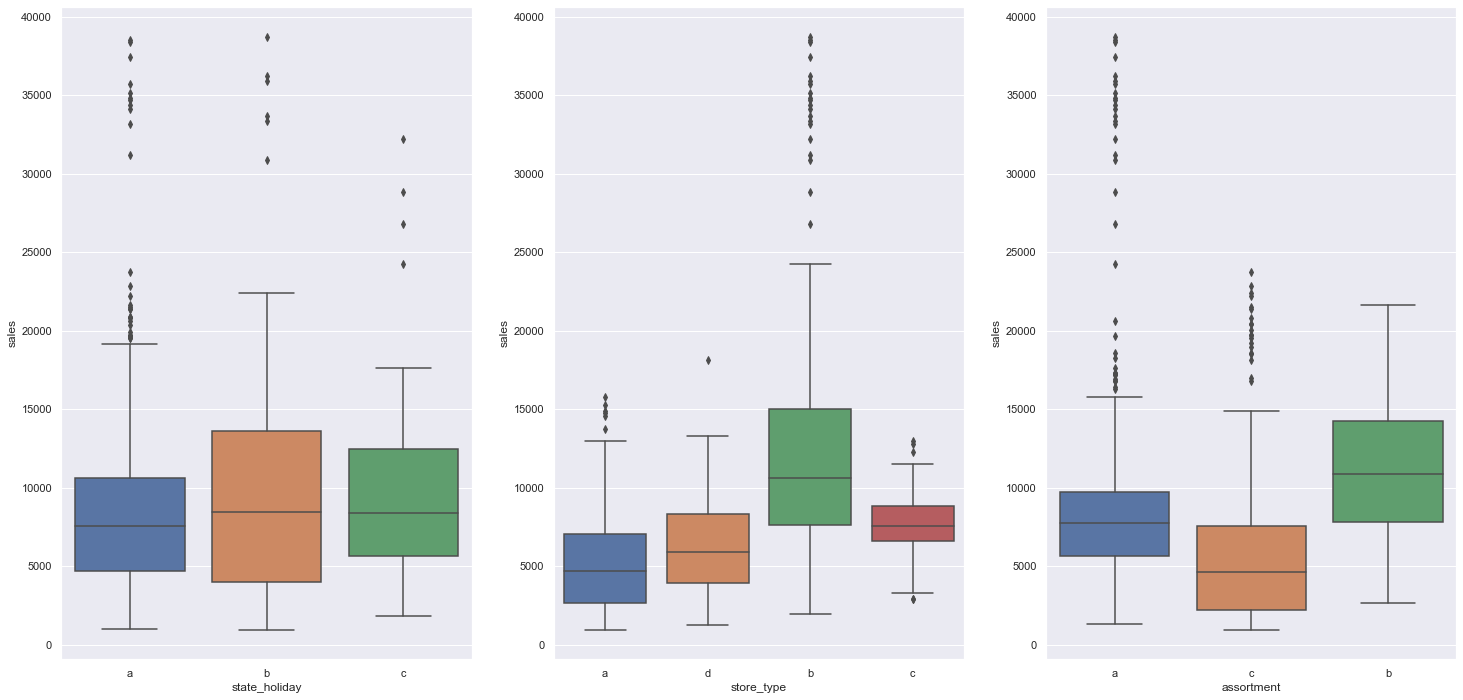

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )

# 2.0. FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1. Mind Map Hypotheses

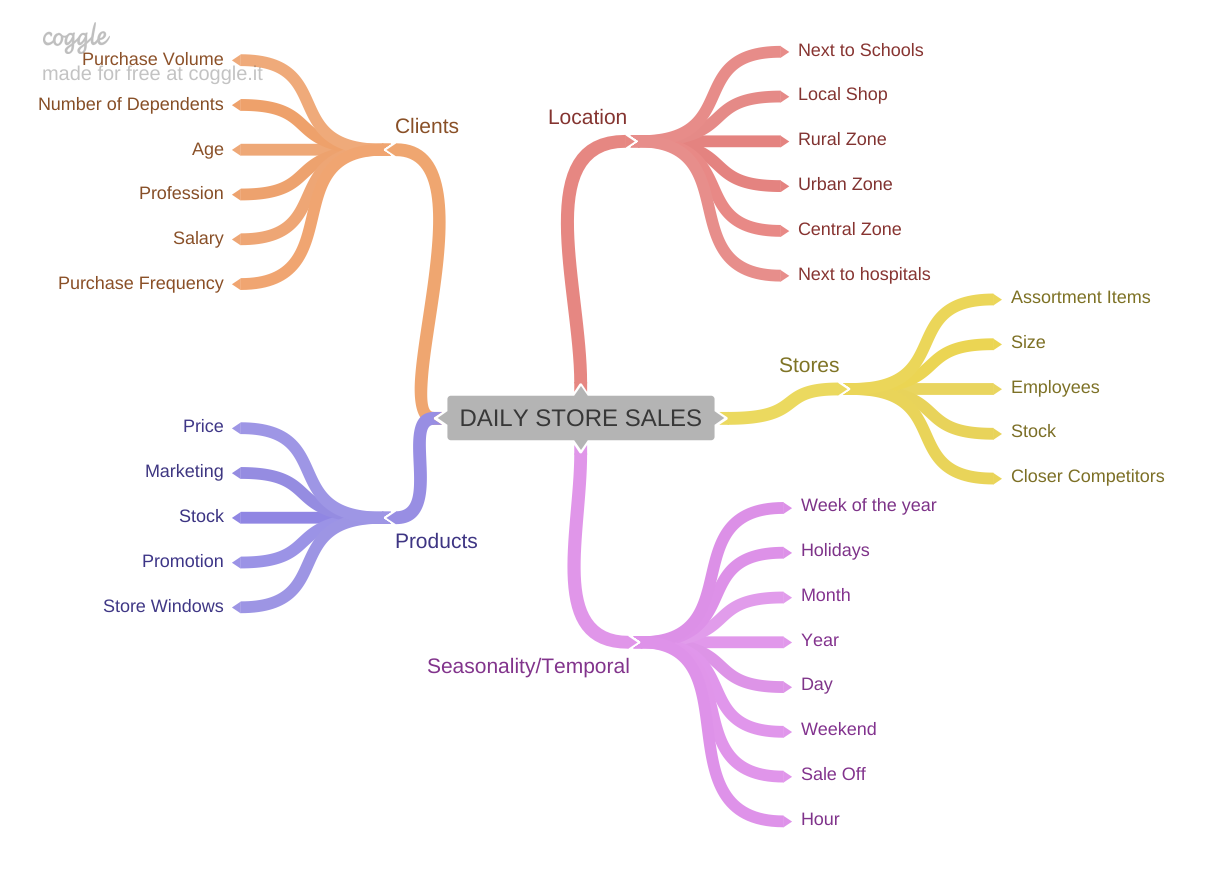

In [22]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Create Hypotheses List

### 2.2.1 Stores Hypotheses

**1.** Stores with more employees are likely to sell more.

**2.** Stores with more stock are likely sell more.

**3.** Larger stores are likely to sell more.

**4.** Stores with larger assortment items are likely to sell more.

**5.** Stores with a higher number of close competitors are likely to sell less.

**6.** Stores with the number of competitors (the longest) are likely to sell more.

### 2.2.2 Products Hypotheses

**1.** Stores that invest more in marketing strategies are likely to sell more.

**2.** Stores that display more products in store windows are likely to sell more.

**3.** Stores with lower prices are likely to sell more.

**4.** Stores with active promotions for longer are more likely to sell more.

**5.** SStores with more sales promotions days are likely to sell more.

**6.** Stores with consecutive promotions are more likely to sell more.

### 2.2.3 Temporal Hypotheses

**1.** Stores are more likely to sell less during school holidays.

**2.** Stores are more likely to sell more over the years.

**3.** Stores are more likely to sell less on weekends.

**4.** Stores are more likely to sell after the 10th of every month.

**5.** Stores that remain open during Christmas time are more likely to sell more.

**6.** Stores are more likely to sell in the second half of the year.

## 2.3 Priority Hypotheses

**1.** Stores with larger assortment items are likely to sell more.

**2.** SStores with a higher number of close competitors are likely to sell less.

**3.** Stores with the number of competitors (the longest) are likely to sell more.

**4.** Stores with active promotions for longer are likely to sell more.

**5.** Stores with more sales promotions days are likely to sell more.

**6.** Stores with consecutive promotions are likely to sell more.

**7.** Stores are likely to sell less during school holidays.

**8.** Stores are likely to sell more over the years.

**9.** Stores are likely to sell less on weekends.

**10.** Stores are likely to sell after the 10th of every month.

**11.** Stores that remain open at Christmas time are likely to sell more.

**12.** Stores are likely to sell in the second half of the year.

## Feature Engineering

In [23]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.weekofyear

# year week
df2['year_week'] = df1['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ) , axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else "easter_holiday" if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [61]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [24]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. VARIABLE FILTERING

In [25]:
df3 = df2.copy()

## 3.1. Row Filtering

In [27]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Columns Selection

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

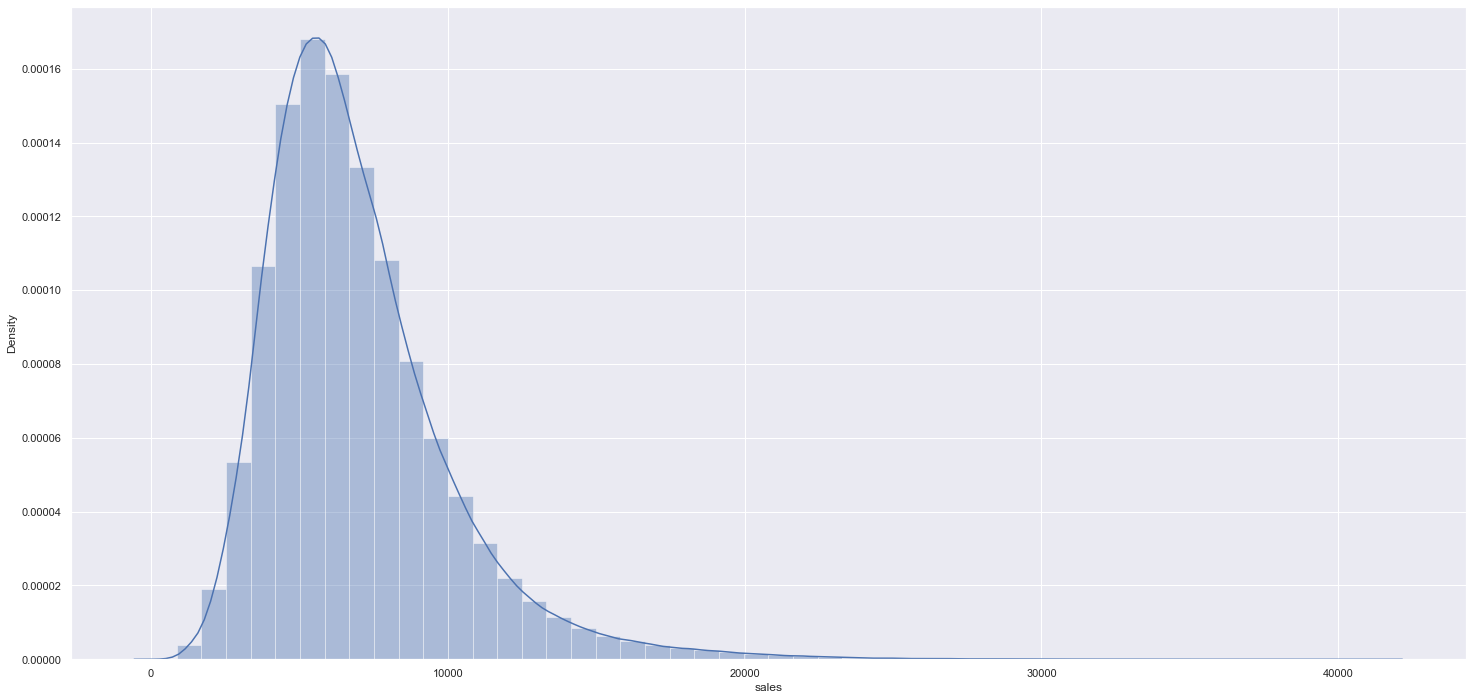

In [32]:
sns.distplot( df4['sales'] )

### 4.1.2. Numerical Variable

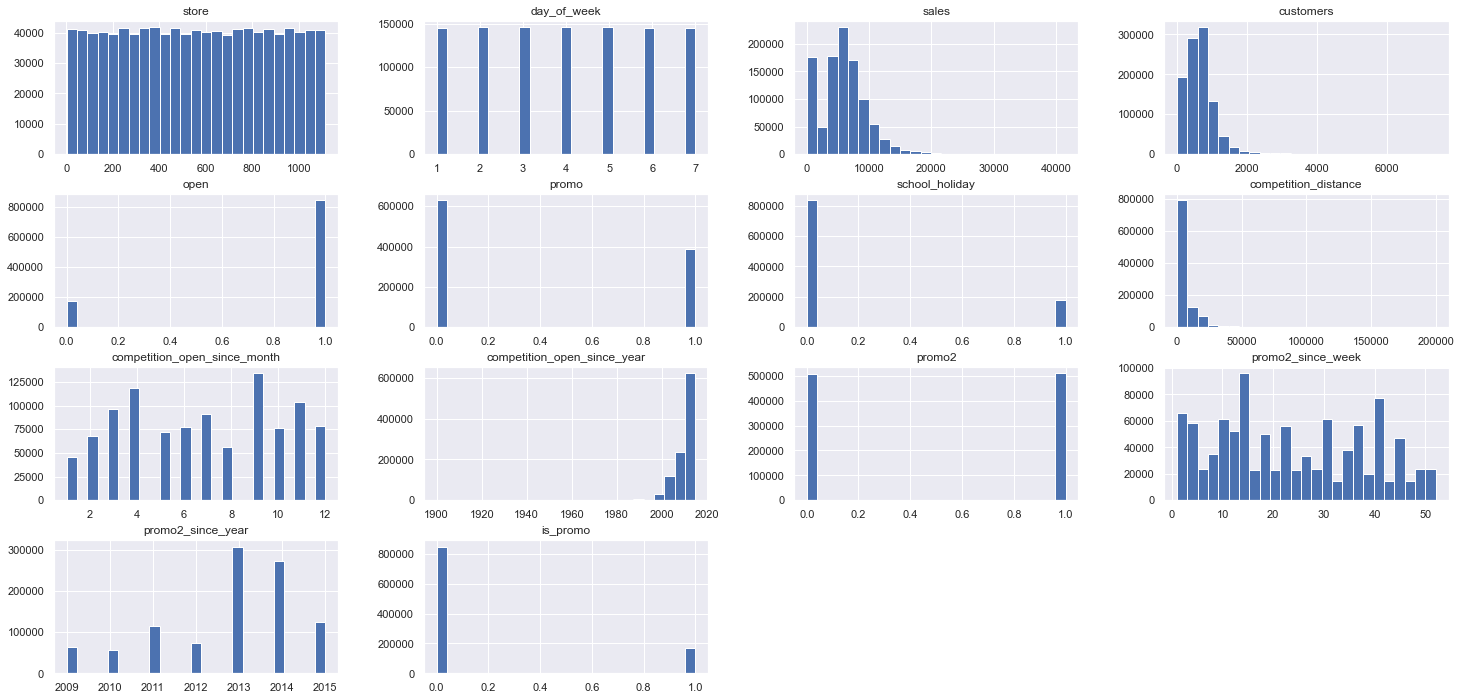

In [33]:
num_attrs.hist( bins=25 );

### 4.1.3. Categorical Variable

In [34]:
df4['store_type'].drop_duplicates()
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

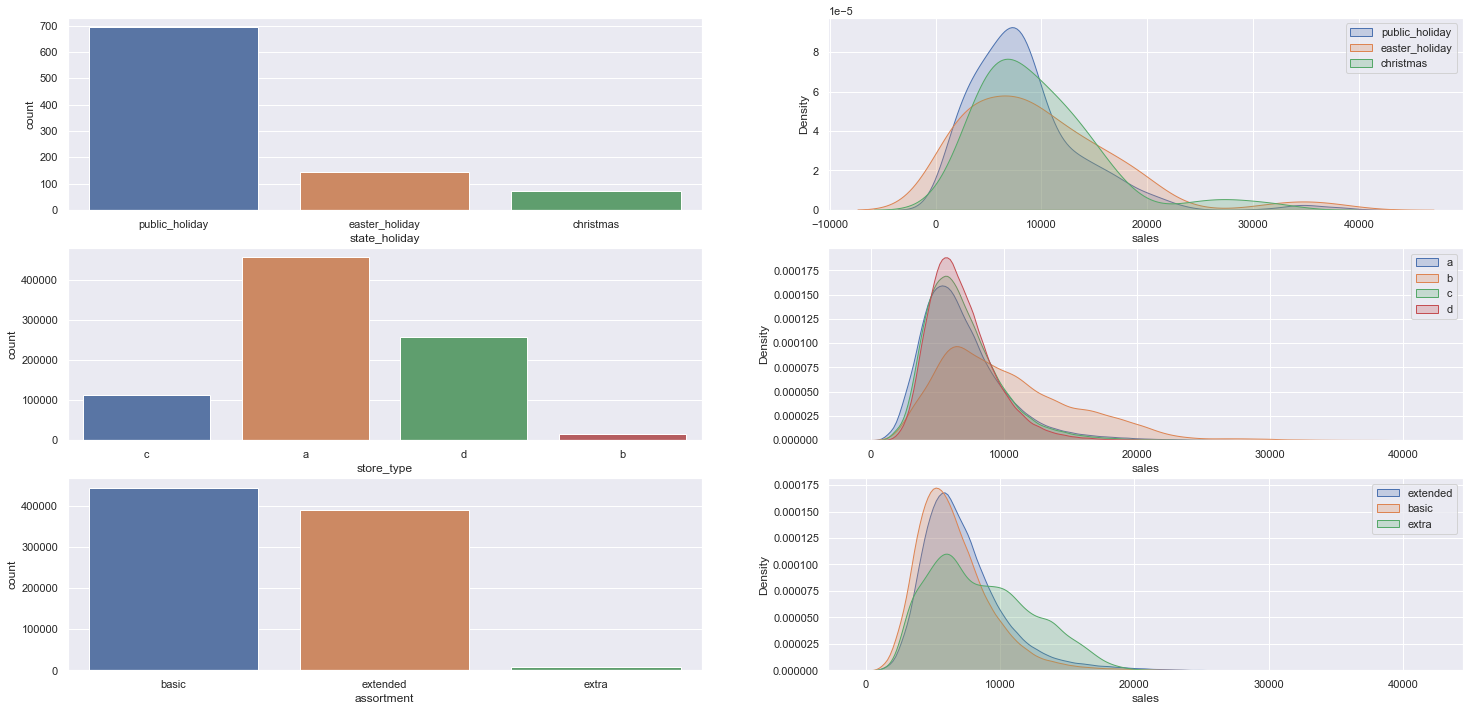

In [35]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()


## 4.2. Bivariate Analysis

### H1. Stores with larger assortment items are likely to sell more.
 - **False** | Stores with LARGER ASSORTMENT sell LESS.

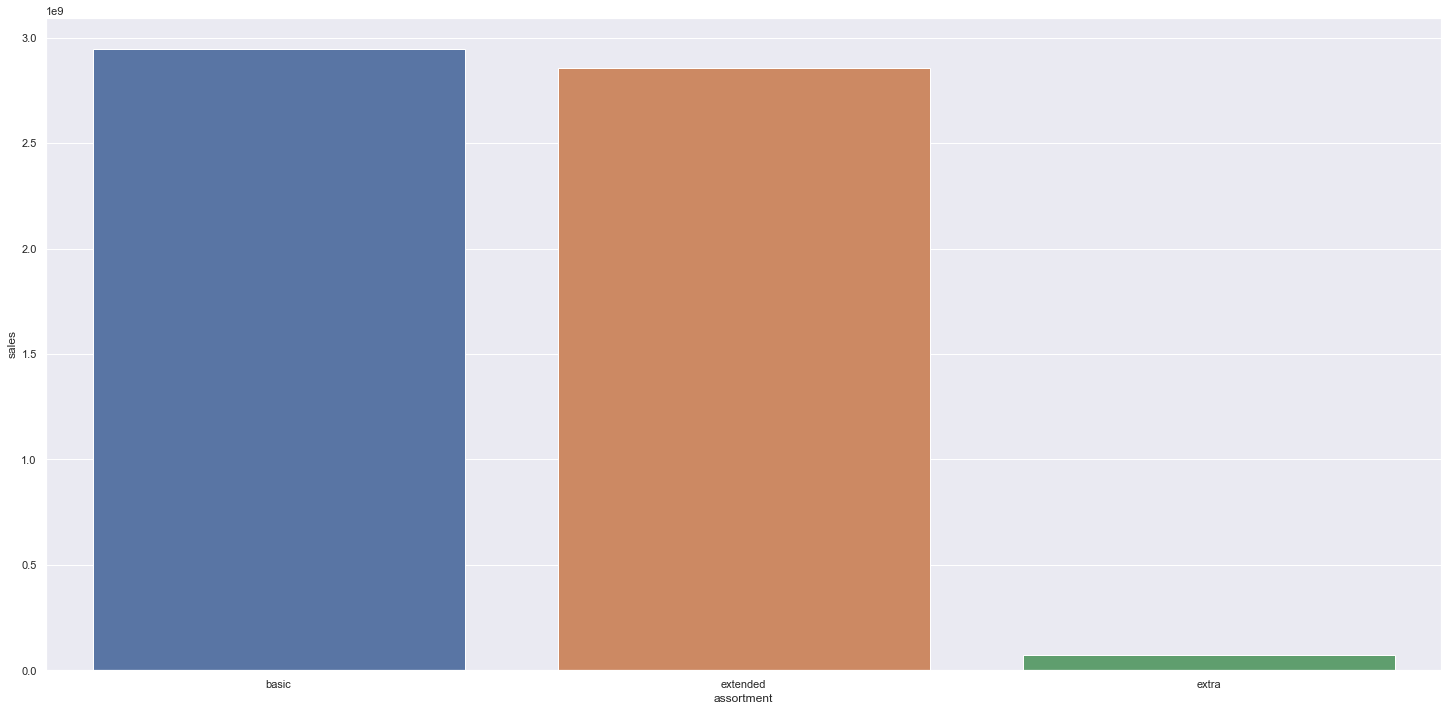

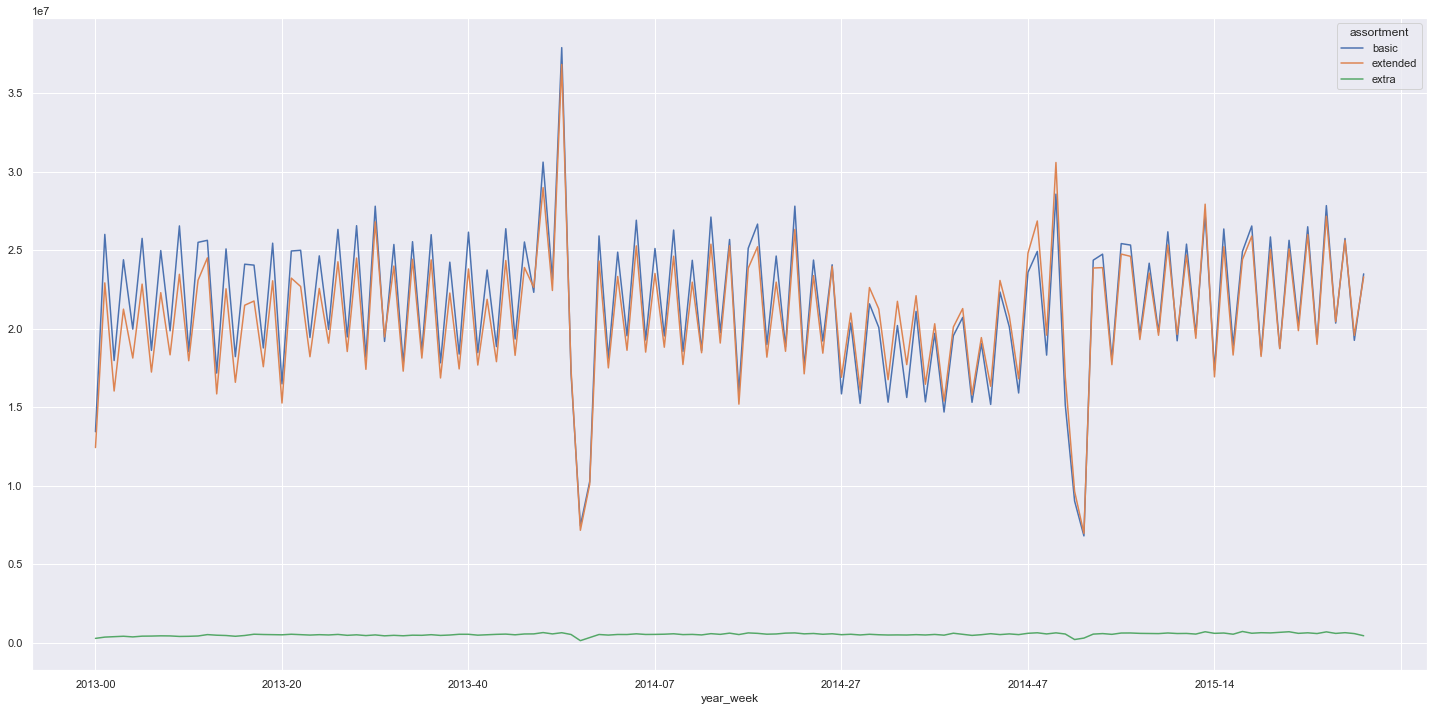

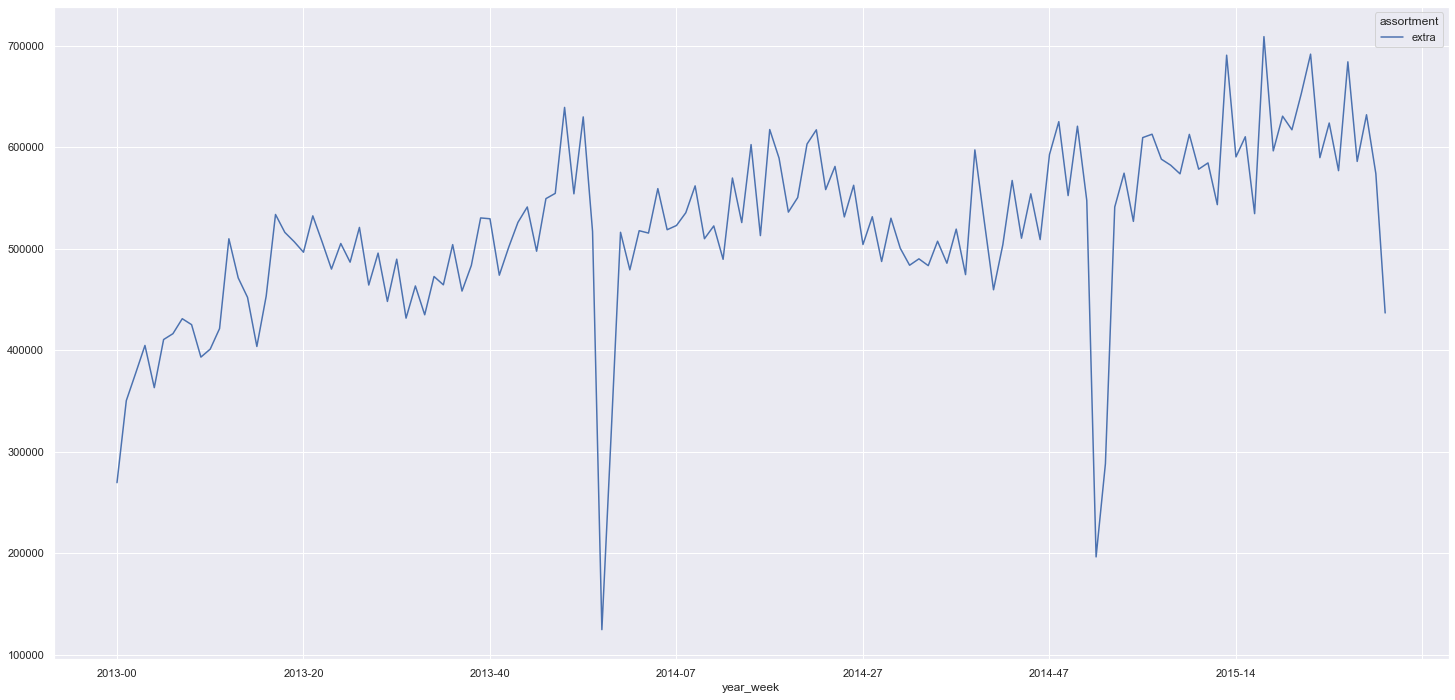

In [36]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2. Stores with a higher number of close competitors are likely to sell less.
 - **False** | Stores with a HIGHER NUMBER of CLOSE sell MORE.

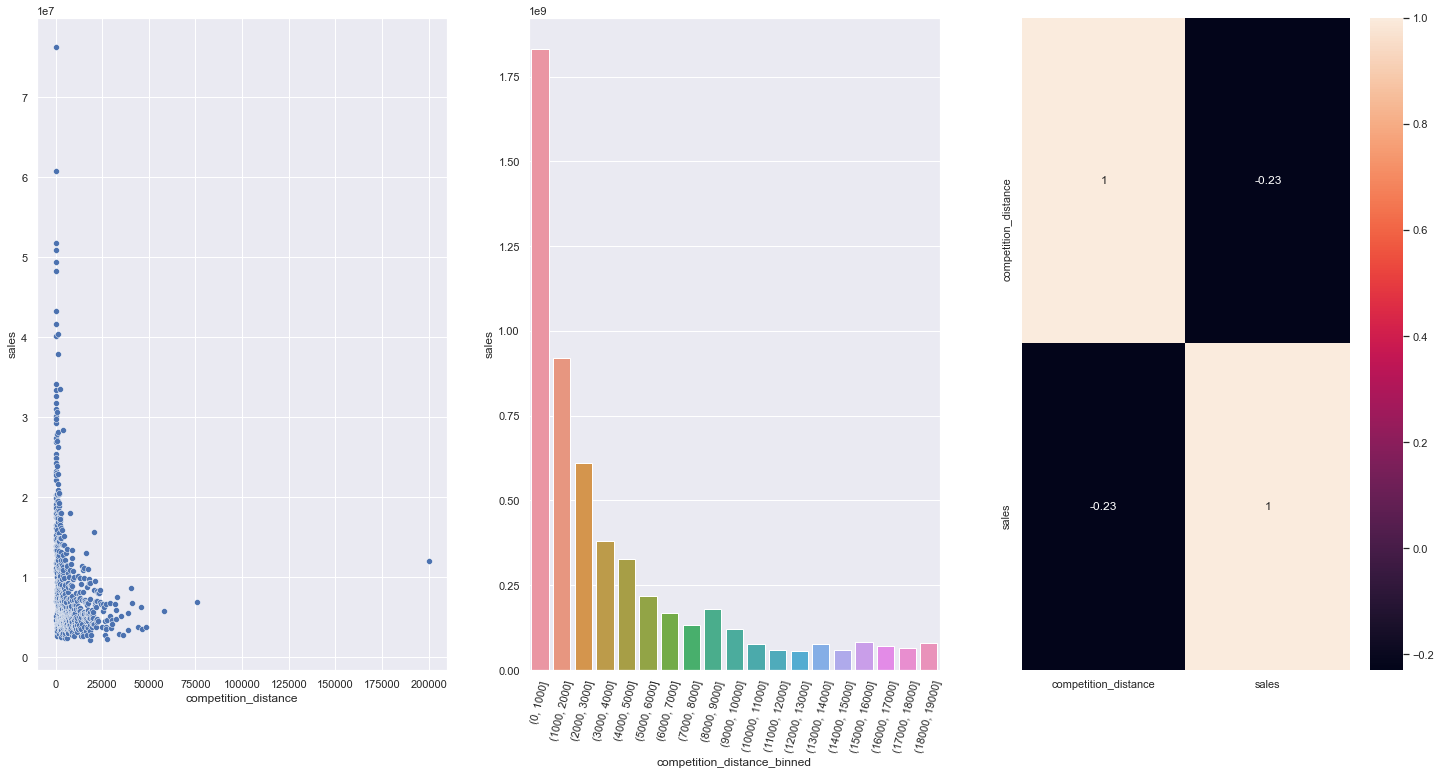

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation = 75 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores with the number of competitors (the longest) are likely to sell more.
 - **False** | Stores with the number of competitors (the longest) sell LESS.

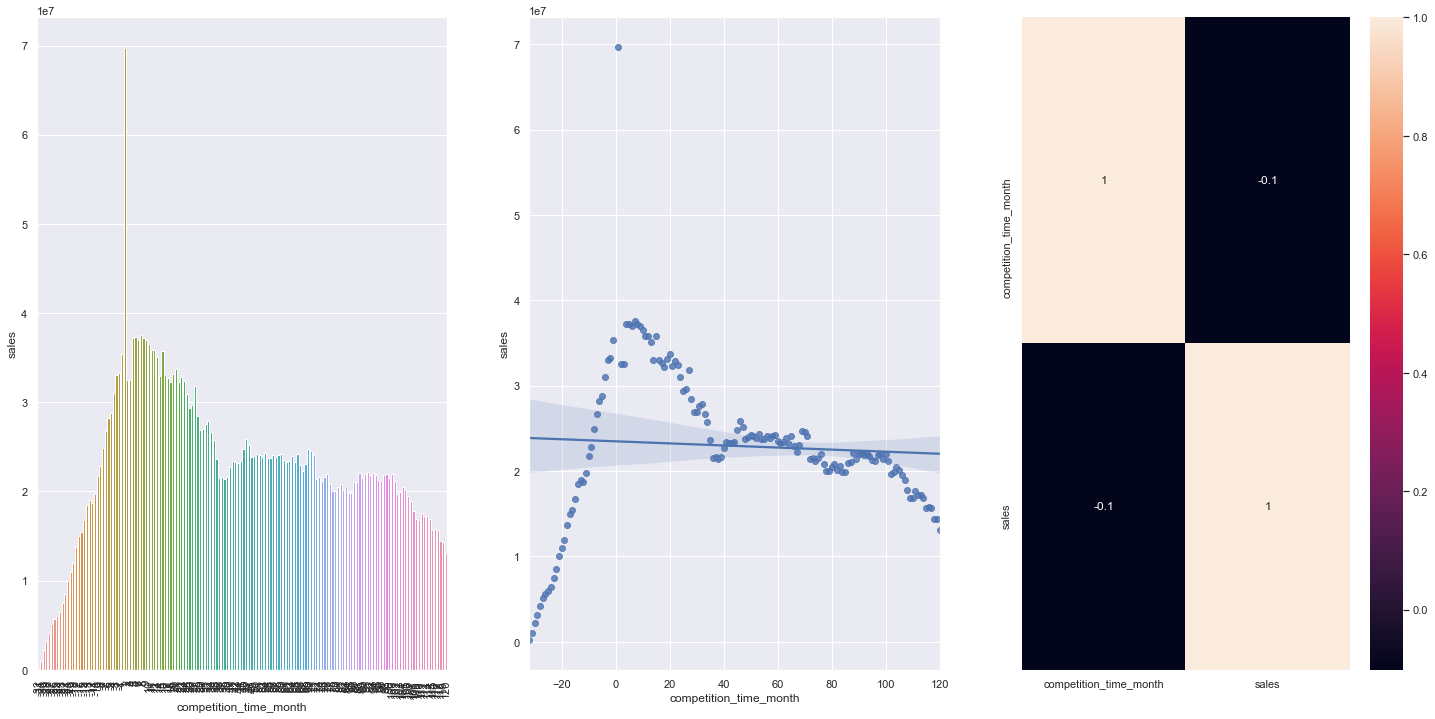

In [38]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
aux2 = aux1[( aux1['competition_time_month'] <= 120 ) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H4.** Stores with active promotions for longer are likely to sell more.
 - **False** | Stores with active promotions for longer sell LESS after a while.

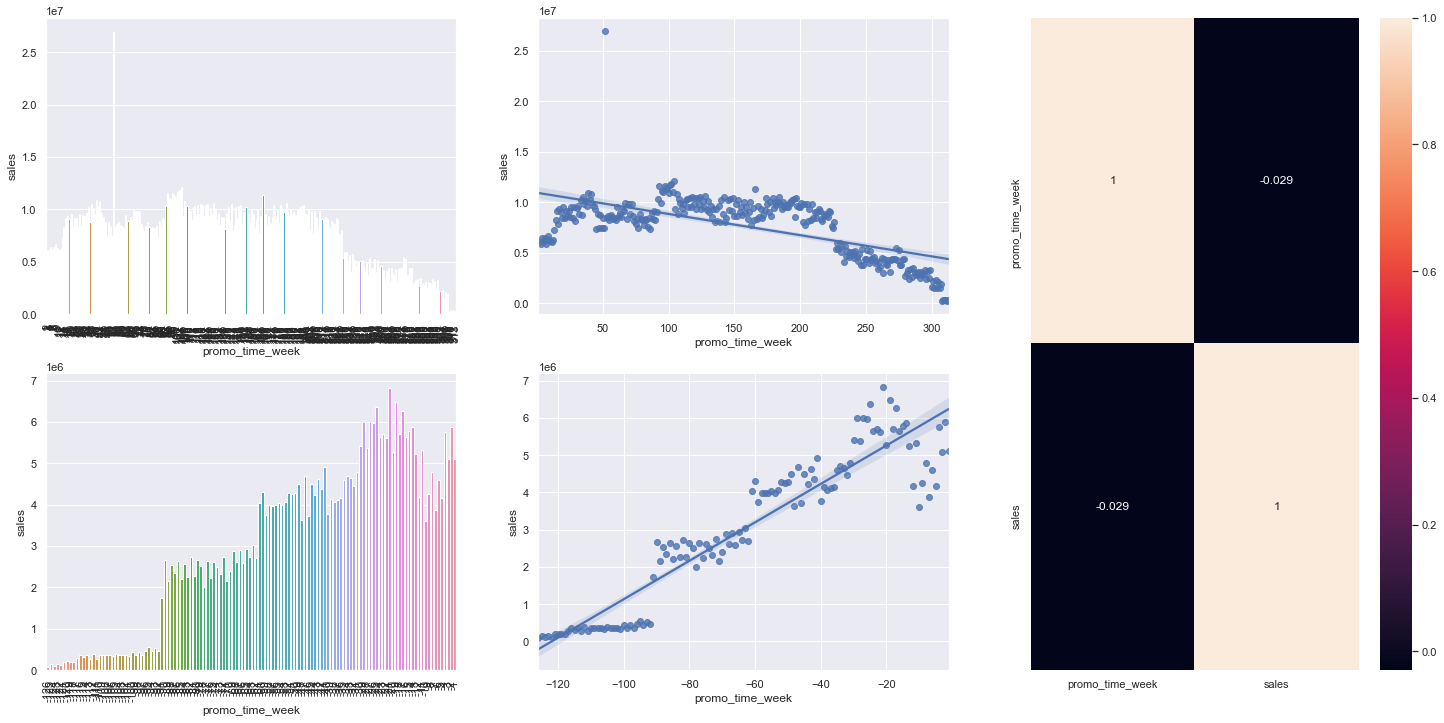

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ]  # extended promo
sns.barplot( x='promo_time_week',  y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ]  # regular promo
sns.barplot( x='promo_time_week',  y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:, 2])
sns.heatmap( aux1.corr(method='pearson'), annot=True );

### <s>**H5.** Stores with more sales promotions days are likely to sell more.</s>

### **H6.** Stores with consecutive promotions are likely to sell more.
 - **False** | Stores with consecutive promotions sell LESS.

In [40]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


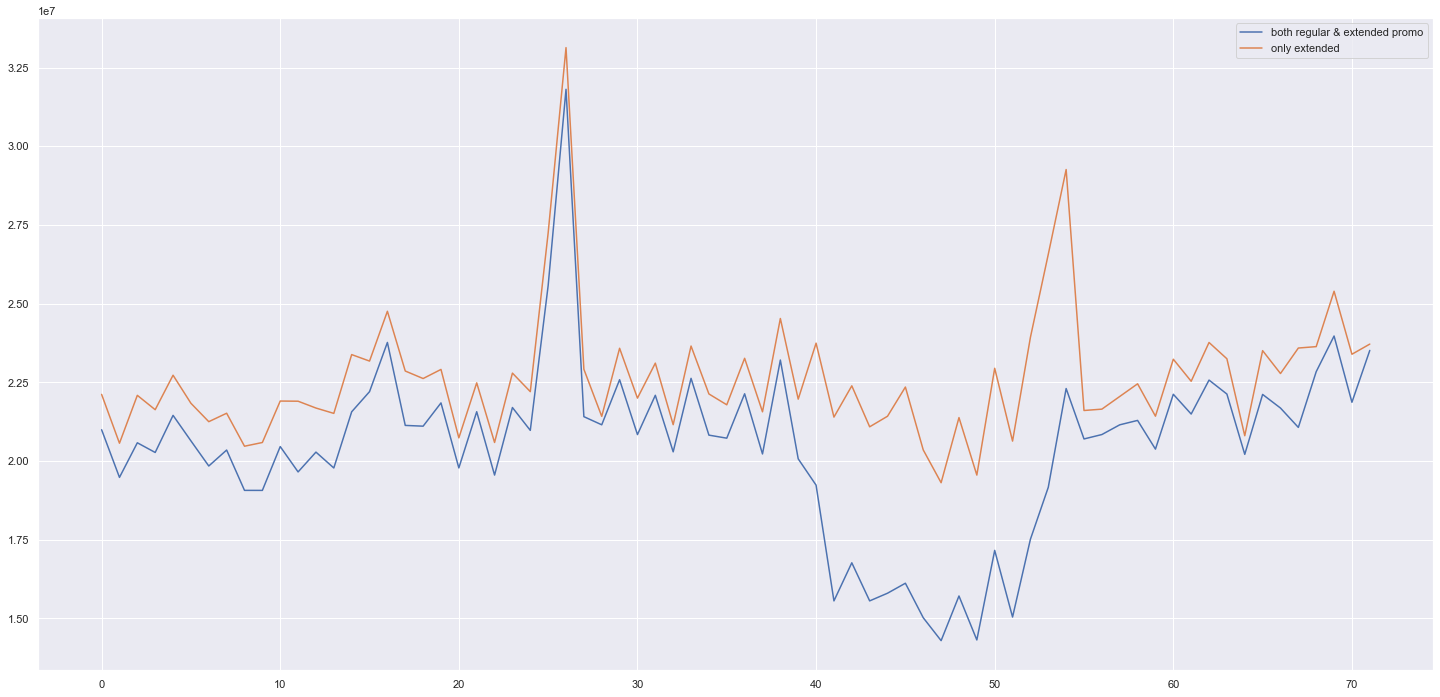

In [41]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax );
plt.legend( labels=['both regular & extended promo', 'only extended'] )

### **H7.** Stores are likely to sell less during school holidays.
 - **True** | Stores sell LESS during school holidays, except July & August.

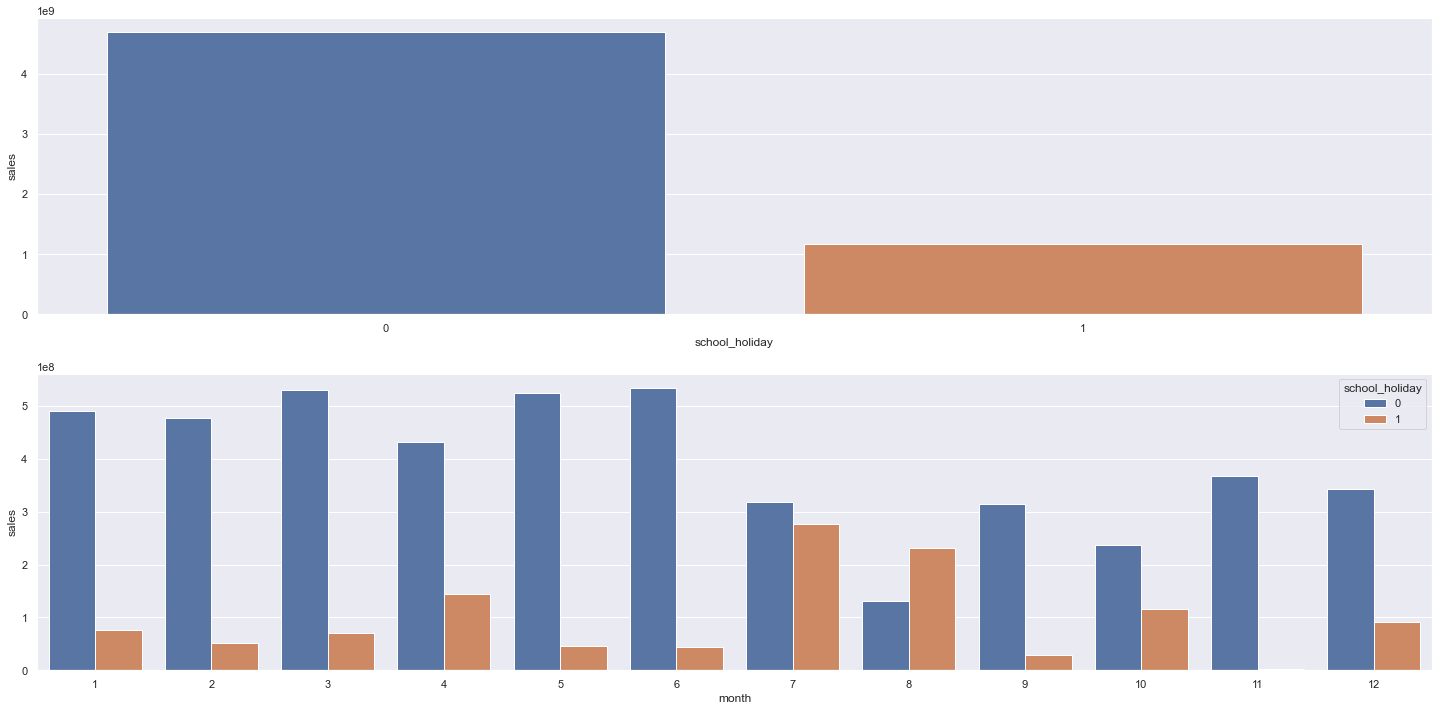

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday',  data=aux2 );


### **H8.** Stores are likely to sell more over the years.
 - **False** | Stores sell LESS over the years.

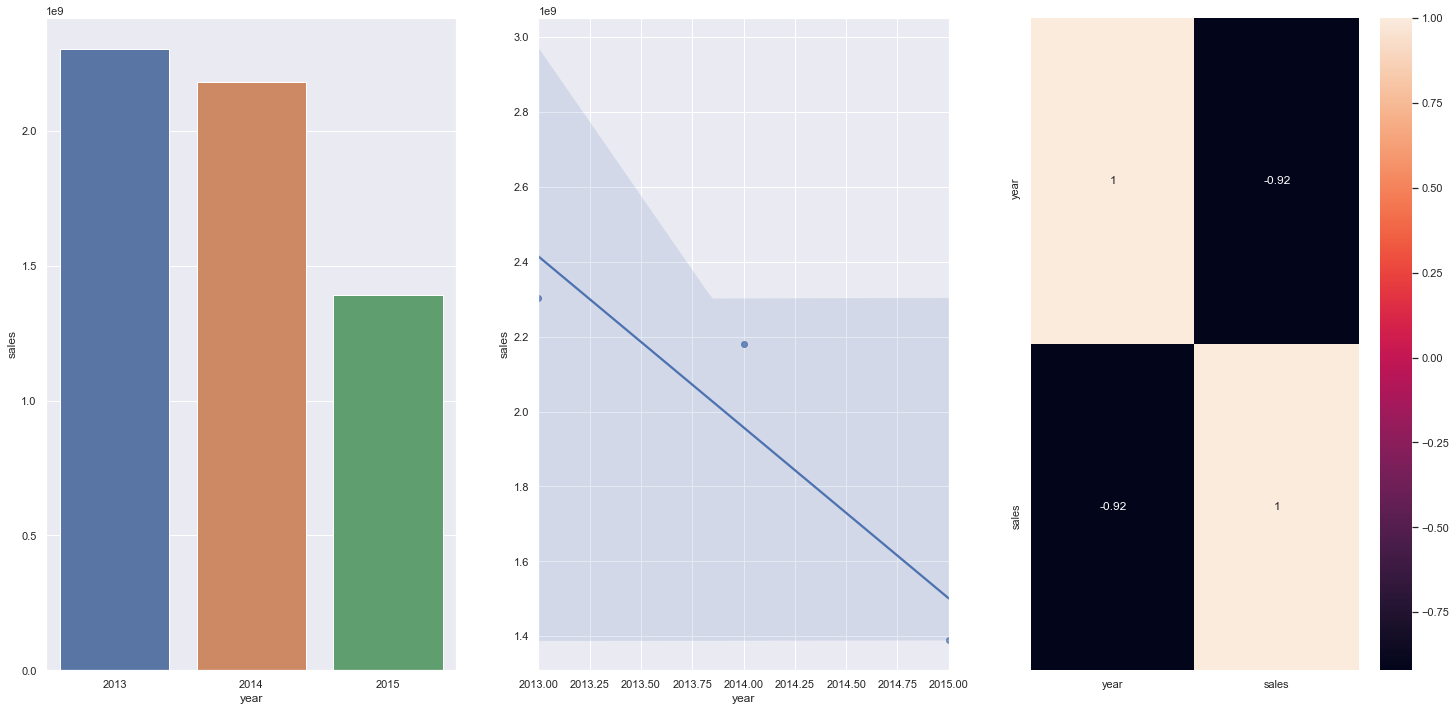

In [43]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H9.** Stores are likely to sell less on weekends.
 - **True** | Stores sell LESS on weekends.

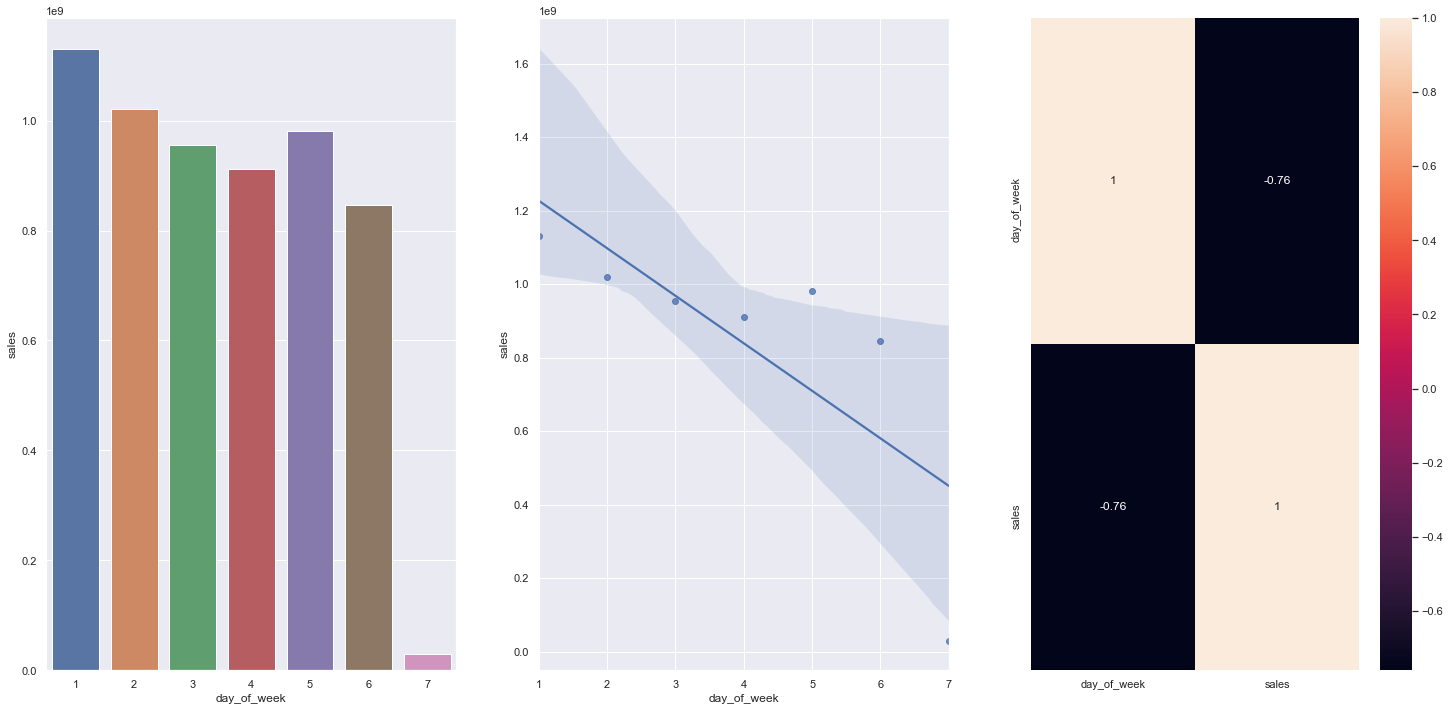

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Stores are likely to sell more after the 10th of every month.
 - **True** | Stores sell MORE after the 10th of every month.

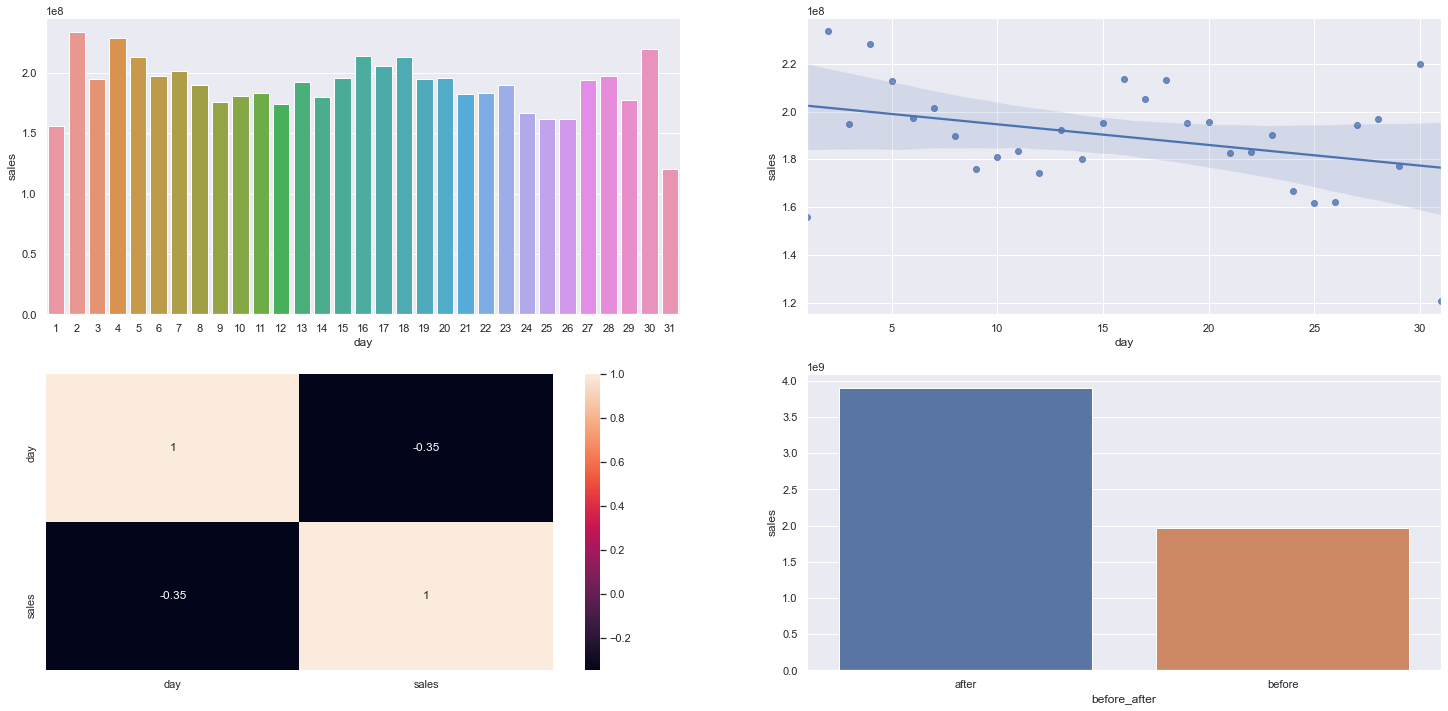

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before' if x <= 10 else 'after' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H11.** Stores that remain open at Christmas time are likely to sell more.
 - **False** | Stores sell LESS at Christmas time.

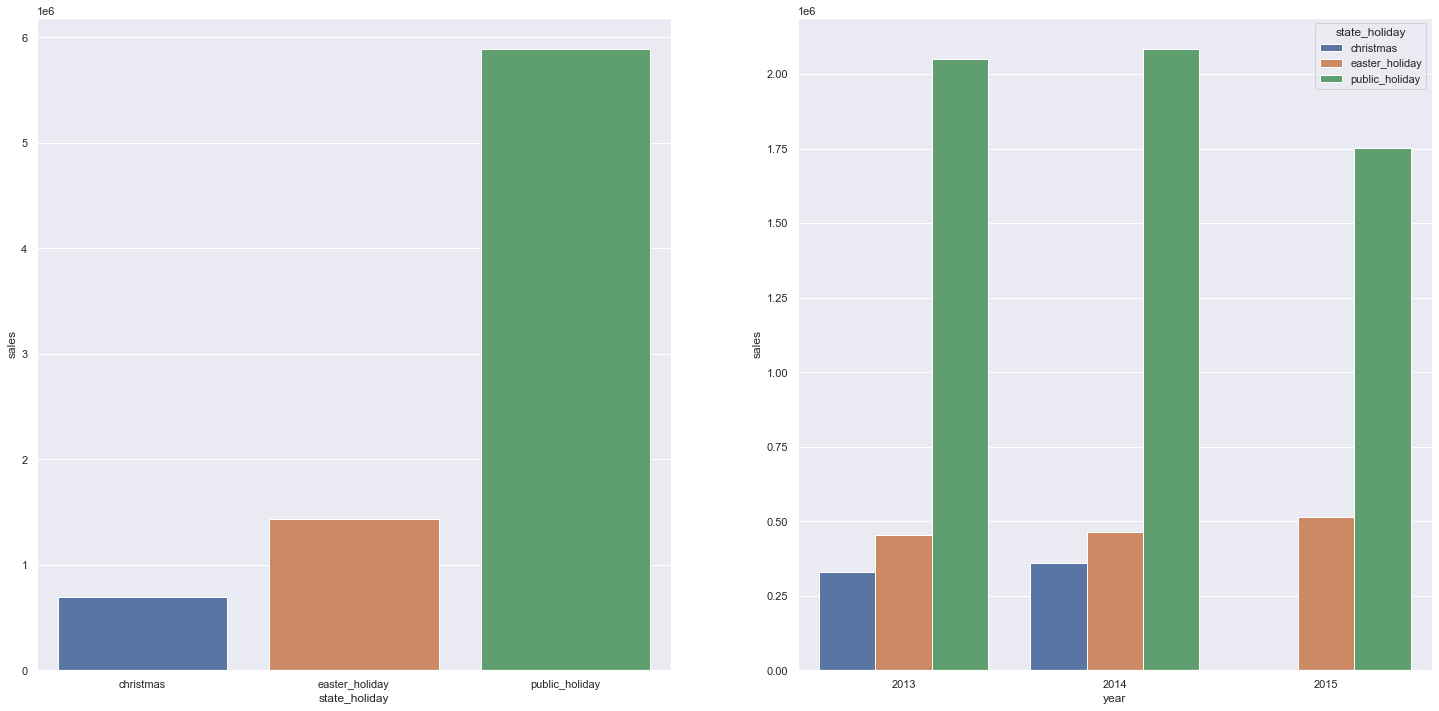

In [46]:
aux = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

plt.subplot( 1, 2, 1 )
sns.barplot( x='state_holiday', y='sales', data=aux1 );

aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
plt.subplot( 1, 2, 2 )
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **H12.** Stores are likely to sell more in the second half of the year.
 - **False** | Stores sell LESS in the second half of the year.

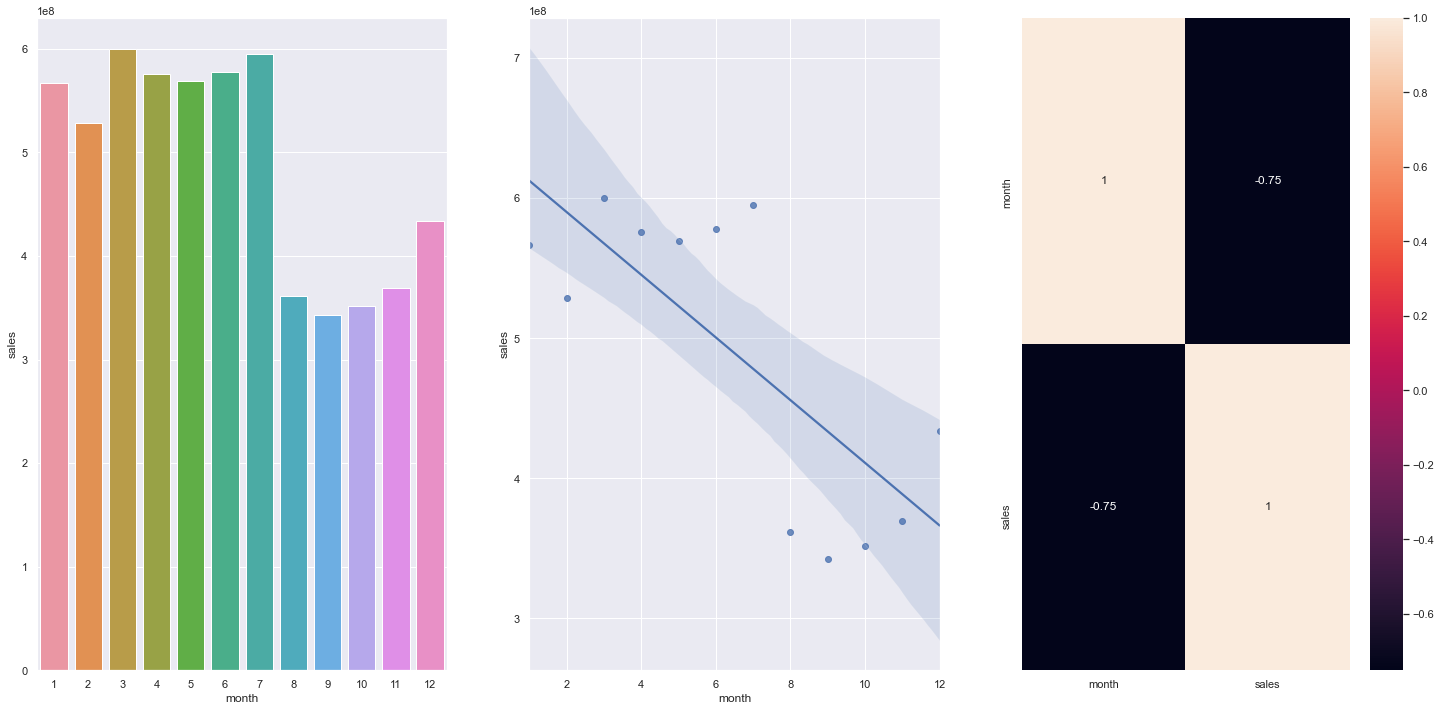

In [47]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.1. Summary of hypotheses

In [48]:
from tabulate import tabulate

In [49]:
tabs = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'True', 'High'],
       ['H8', 'False', 'Medium'],
       ['H9', 'True', 'High'],
       ['H10', 'True', 'Low'],
       ['H11', 'False', 'High'],
       ['H12', 'False', 'High']]

print(tabulate(tabs, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            True          High
H8            False         Medium
H9            True          High
H10           True          Low
H11           False         High
H12           False         High


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

In [50]:
num_attrs.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


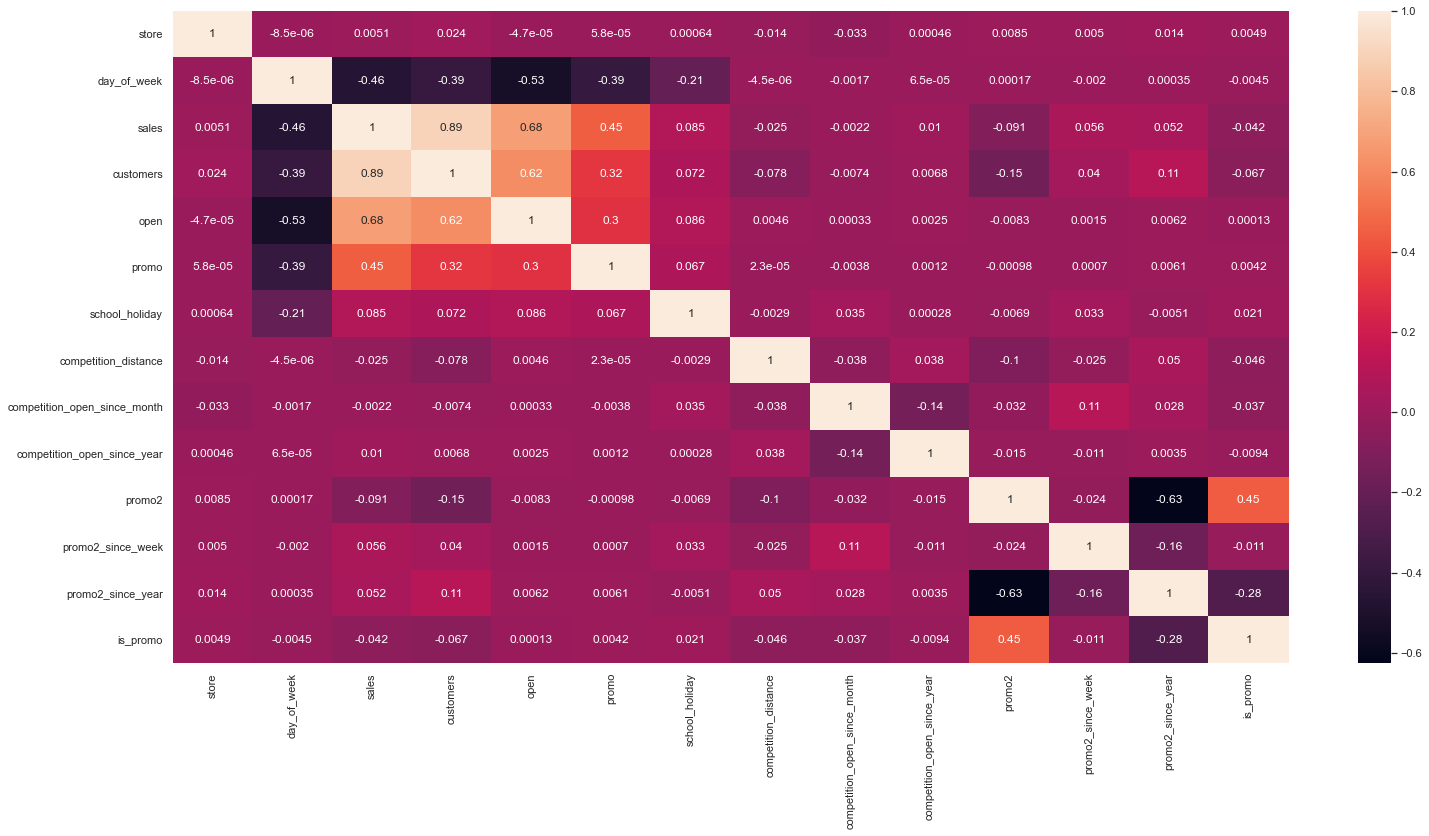

In [51]:
correlation = num_attrs.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attributes

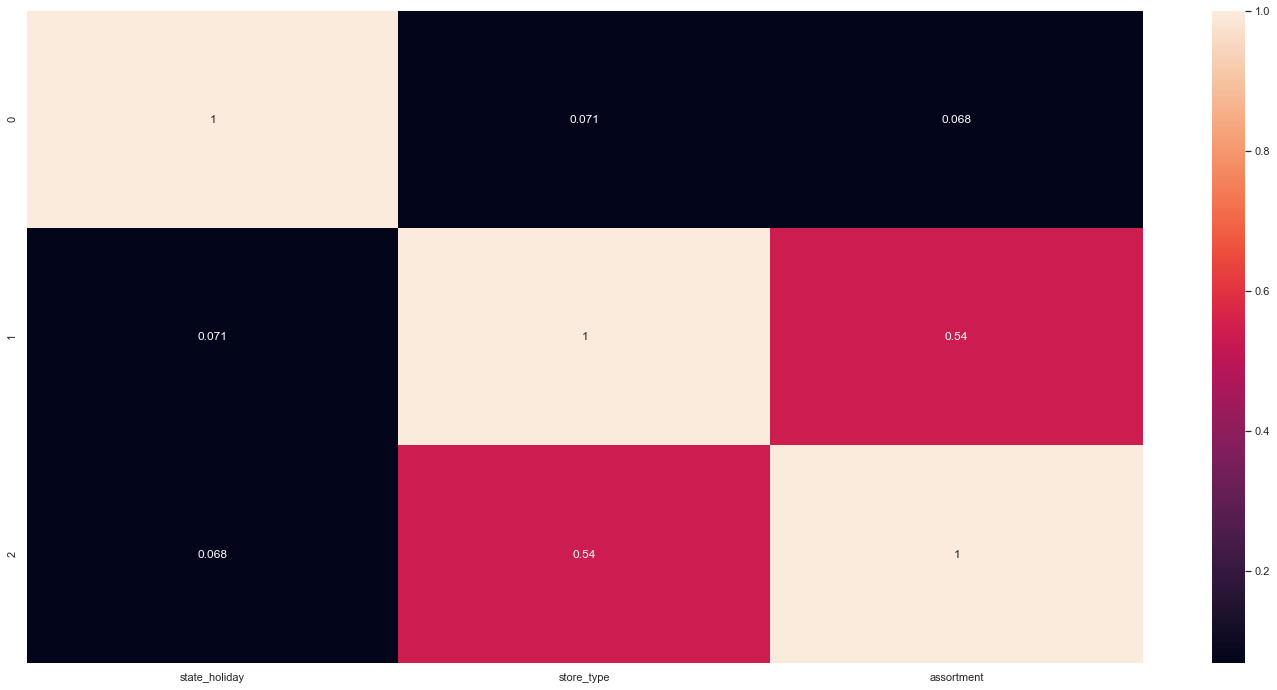

In [57]:
# only categorical attributes
a = df4.select_dtypes( include='object' )

# Calculate Cramer's V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
df = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

df.set_index( df.columns )

sns.heatmap( df, annot=True);

# 5.0. DATA PREPARATION

In [99]:
df5 = df4.copy()

## <s> 5.1. Normalization </s>

## 5.2. Rescaling

In [101]:
rs = RobustScaler()
mms = MinMaxScaler()

In [102]:
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3. Transformation

### 5.3.1. Encoding

In [103]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_map = {
    'basic': 1,
    'extra': 2,
    'extended': 3
}

df5['assortment'] = df5['assortment'].map( assortment_map )

In [ ]:
# day_of_week
# day
# month
